In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Bell_Amundsen_Extent = pd.read_excel(filepath, sheet_name='Bell-Amundsen-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Bell_Amundsen_Extent)
fp.date_time(Bell_Amundsen_Extent)

,Extent,Date
0,1179855.894,1979-01-01
1,879585.254,1979-02-01
2,791619.096,1979-03-01
3,1254912.071,1979-04-01
4,1620142.247,1979-05-01
...,...,...
533,1556568.455,2023-06-01
534,1917507.979,2023-07-01
535,2601630.327,2023-08-01
536,2534223.780,2023-09-01


In [5]:
scaler = MinMaxScaler()
Bell_Amundsen_Extent['Extent'] = scaler.fit_transform(Bell_Amundsen_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 5
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Bell_Amundsen_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((522, 12, 1), (522,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Bell_Amund_model_LT5/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 13s 166ms/step - loss: 0.2431 - root_mean_squared_error: 0.4930 - val_loss: 0.2250 - val_root_mean_squared_error: 0.4744
Epoch 2/50
53/53 [==============================] - 7s 143ms/step - loss: 0.1090 - root_mean_squared_error: 0.3302 - val_loss: 0.0576 - val_root_mean_squared_error: 0.2401
Epoch 3/50
53/53 [==============================] - 7s 141ms/step - loss: 0.0436 - root_mean_squared_error: 0.2088 - val_loss: 0.0535 - val_root_mean_squared_error: 0.2312
Epoch 4/50
53/53 [==============================] - 8s 148ms/step - loss: 0.0410 - root_mean_squared_error: 0.2026 - val_loss: 0.0534 - val_root_mean_squared_error: 0.2312
Epoch 5/50
53/53 [==============================] - 8s 149ms/step - loss: 0.0394 - root_mean_squared_error: 0.1985 - val_loss: 0.0510 - val_root_mean_squared_error: 0.2259
Epoch 6/50
53/53 [==============================] - 7s 141ms/step - loss: 0.0379 - root_mean_squared_error: 0.1948 - val_loss: 0.0484 - val

Epoch 28/50
53/53 [==============================] - 1s 25ms/step - loss: 0.0150 - root_mean_squared_error: 0.1223 - val_loss: 0.0263 - val_root_mean_squared_error: 0.1622
Epoch 29/50
53/53 [==============================] - 7s 125ms/step - loss: 0.0148 - root_mean_squared_error: 0.1218 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1551
Epoch 30/50
53/53 [==============================] - 7s 136ms/step - loss: 0.0156 - root_mean_squared_error: 0.1251 - val_loss: 0.0239 - val_root_mean_squared_error: 0.1545
Epoch 31/50
53/53 [==============================] - 7s 132ms/step - loss: 0.0142 - root_mean_squared_error: 0.1193 - val_loss: 0.0235 - val_root_mean_squared_error: 0.1534
Epoch 32/50
53/53 [==============================] - 7s 129ms/step - loss: 0.0139 - root_mean_squared_error: 0.1178 - val_loss: 0.0234 - val_root_mean_squared_error: 0.1530
Epoch 33/50
53/53 [==============================] - 1s 27ms/step - loss: 0.0153 - root_mean_squared_error: 0.1235 - val_loss: 0.0249 - 

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

5.158381179968516 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

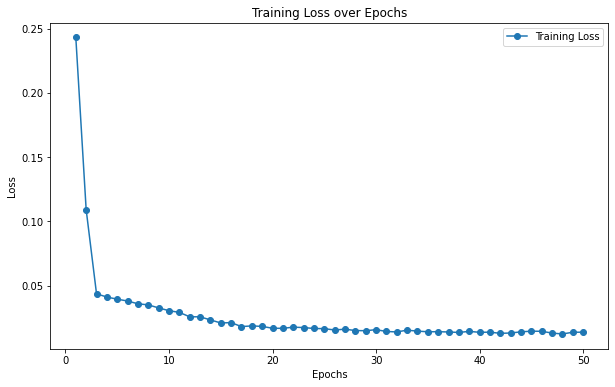

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

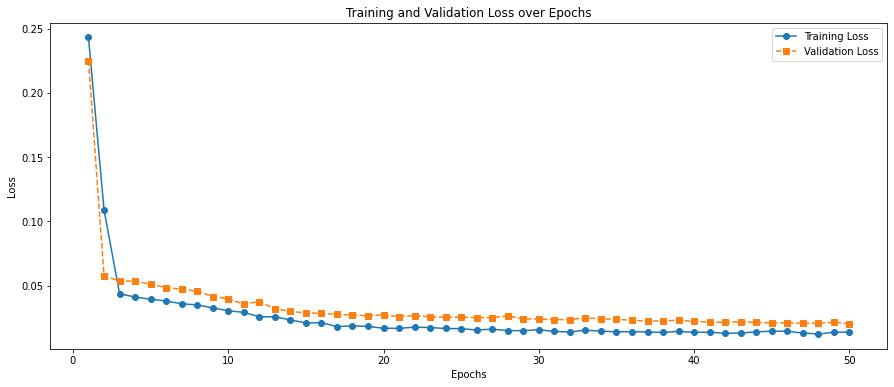

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Bell_Amund_model_LT5/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 9ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.11941086113412898
MAE : 0.1012030194928944


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,2.132232e+06,1856673.675
1,1.829194e+06,1914289.680
2,1.514082e+06,1802244.842
3,1.180770e+06,1202791.069
4,9.177947e+05,752834.272
5,7.066876e+05,451914.219
6,5.841437e+05,439855.813
7,7.278910e+05,807857.307
8,1.122987e+06,1184280.145
9,1.480331e+06,1468308.405


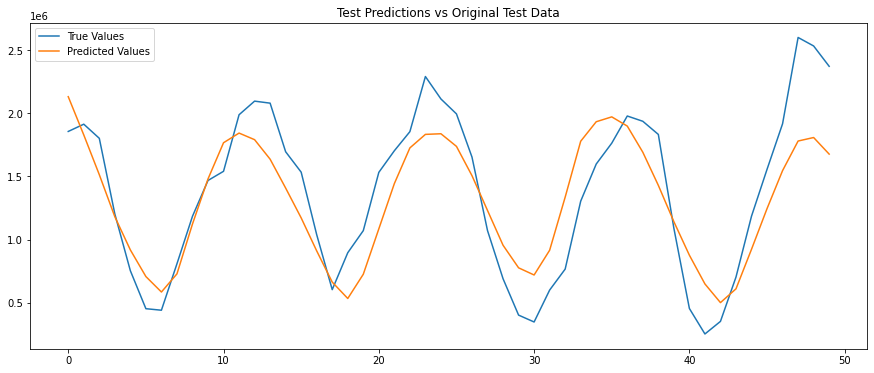

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 11ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

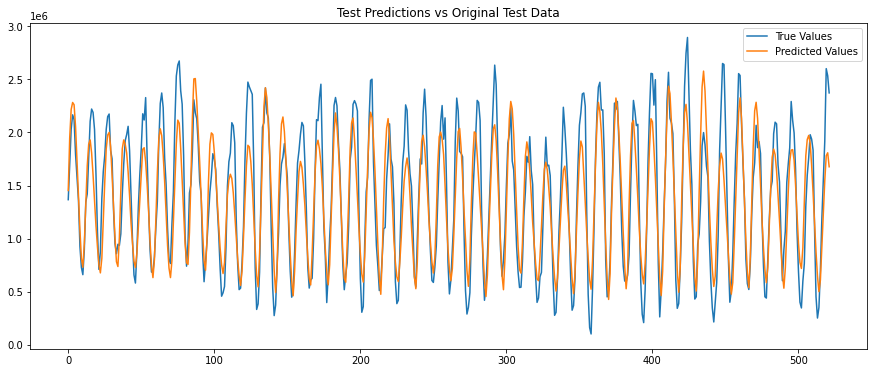

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()